# **Tutorial: Data Analysis on Reddit**
https://reddit.com is a popular social media website that hosts a collection of forums (“subreddits”) where users aggregate certain types of content (ex: /r/catpics) or discuss certain topics (ex: /r/politics). There is a wealth of information to be gleaned from social, scientific, anthropological and other perspectives in reaping and analyzing the data on reddit, and it can be quite fun to do so as well. In this tutorial we provide a simple, extensible pipeline that guides the user through collecting, sanitizing, analyzing, and presenting (through graphs and summary statistics) that kind of data; go through it yourself and once you learn a few simple techniques, you’ll be able to adapt these methods to gather whatever kind of reddit data you want and analyze it in a variety of ways for fun and profit.

## **Part 1) Importing the relevant libraries**
For this project we will need a few different packages:


*   **numpy**: a scientific computing library that contains versatile representation of arrays and a variety of mathematical functions
*   **pandas**: a data analysis and manipulation library
*   **matplotlib**: a pair of robust plotting libraries
*   **plotnine**: library to compose plots
*   **sklearn**: machine learning library
*   **statsmodels**: a library that provides tools for statistical analysis
*   **praw**: a data scraping library made to collect posts, comments, and other information from reddit.com
*   **tqdm**: a simple library that adds loading bars for loops, optional


In [49]:
# To install praw:
# import sys
# !{sys.executable} -m pip install praw

import numpy as np
import pandas as pd
from plotnine import *
from matplotlib import pyplot as plt
import statsmodels.formula.api as sm
import sklearn.ensemble
import sklearn.model_selection
import sklearn.metrics
import praw
from tqdm import tqdm_notebook

## **Part 2) Data Collection and Parsing**
Now that we have our libraries, the next step is to start scraping our data and arranging it in an easily manipulable format. In the example below, where we quickly scrape two datasets and store them in organized dataframes: 1) the top 100 posts from the subreddit /r/coronavirus and create a dataframe with post titles, authors, and other relevant fields and 2) all comments from a single highly-trafficked post along with comment author, score, etc.

If you want more information on praw and how to use it for more specific queries or other types of reddit information, check out the quick start guide in the official praw docs here: https://praw.readthedocs.io/en/latest/getting_started/quick_start.html

In [2]:
# initialize praw instance
reddit = praw.Reddit(client_id="BntfP_snMrMyVQ", client_secret="m2VtNI8UehvHELrVeoXyrR_SFY4", user_agent="my user agent")

# get dataset 1, a set of reddit posts
# choose a subreddit to scrape (for example, "news" for reddit.com/r/news) and scrape top N posts
# in this case we get the top 100 posts from the /r/coronavirus subreddit
n = 100
sub = reddit.subreddit("coronavirus")
posts = reddit.subreddit("coronavirus").top(limit=n)

# extract attributes from posts
posts_data = []
for p in tqdm_notebook(posts, total=n):
  # check if author is deleted or suspended
  banned = True if p.author == None else False
  try:
    c = p.author.created
  except AttributeError:
    banned = True

  # load attributes into dataframe
  posts_data.append({'id': p.id, 
                     'title': p.title,
                     'author': p.author.name if not banned else None,
                     'author_flair': p.author_flair_text,
                     'author_link_karma': p.author.link_karma if not banned else -1,
                     'author_comment_karma': p.author.comment_karma if not banned else -1,
                     'author_start_date': p.author.created_utc if not banned else -1,
                     'flair': p.link_flair_text,
                     'upvotes': p.ups,
                     'upvote_ratio': p.upvote_ratio,
                     'comments': p.num_comments,
                     'crossposts': p.num_crossposts,
                     'type': 'self' if p.is_self else 'link',
                     'edited': p.edited,
                     'gilded': p.gilded > 0,
                     'silver': p.gildings.get('gid_1', 0), # various types of awards users can give reddit posts below
                     'gold': p.gildings.get('gid_2', 0),
                     'platinum': p.gildings.get('gid_3', 0),
                     'total_awards': p.total_awards_received
                     })
  
# show first 10 rows of post data
posts_df = pd.DataFrame(posts_data)
pd.set_option('display.max_columns', None)
print(posts_df[:10])

/opt/miniconda3/envs/cmsc320/lib/python3.6/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



       id                                              title  \
0  fgi2pi  Even if COVID-19 is unavoidable, delaying infe...   
1  fn1mtn  Gino Fasoli was 73 years old. He was italian a...   
2  gdkt54  Irish people help raise 1.8 million dollars fo...   
3  fn3j0w                 How to stop a virus from spreading   
4  fxdwoa  All 11 Coronavirus patients in Greenland have ...   
5  fjcz60  An Italian hospital ran out of ICU valves. A l...   
6  fl0pdv  Mark Cuban says bailed out companies should ne...   
7  fo78n6  Governor Cuomo: “My mother is not expendable. ...   
8  fnohv7  Let’s be clear. Again. The virus does not spre...   
9  g03smi  Kentucky church fills Easter service to near c...   

              author author_flair  author_link_karma  author_comment_karma  \
0           finchdad         None              45598                120725   
1          Franky_95         None              25650                  1779   
2      willmannix123         None              10991        

In [3]:
# get dataset 3, a set of reddit comments
# choose a post to scrape (you can get the post id from its url) and scrape all comments
# in this case we get comments from the top post of all time on the /r/coronavirus subreddit
n = 1
sub = reddit.subreddit("subredditoftheday")
post = next(reddit.subreddit("subredditoftheday").top(limit=n))
post.comments.replace_more(limit=None)
comments = post.comments.list()

# extract attributes from comments
comments_data = []
for c in tqdm_notebook(comments, total=post.num_comments):
  # check if author is deleted or suspended
  banned = True if c.author == None else False
  try:
    t = c.author.created
  except Exception as e:
    banned = True

  # load attributes into dataframe
  comments_data.append({'id': c.id, 
                     'body': c.body,
                     'author': c.author.name if not banned else None,
                     'author_flair': c.author_flair_text,
                     'author_link_karma': c.author.link_karma if not banned else 0,
                     'author_comment_karma': c.author.comment_karma if not banned else 0,
                     'author_start_date': c.author.created_utc if not banned else 0,
                     'author_submitted': c.is_submitter if not banned else 0,
                     'upvotes': c.score,
                     'edited': p.edited
                     })
  
# show first 10 rows of post data
comments_df = pd.DataFrame(comments_data)
print(comments_df[:10])

/opt/miniconda3/envs/cmsc320/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



        id                                               body  \
0  dbvei4j  Just a quick mod note. \n\nWe made ourselves S...   
1  dbv6rwb  Thought for sure this was coming from /r/subre...   
2  dbv6f0b                                             RIGGED   
3  dbv6jl2  Pack it up everyone, this sub's done, they're ...   
4  dbv6tgz       Would have made a great April Fool's prank.    
5  dbv6ezt                                        Inception.    
6  dbv7ptx                                 **INCEPTION HORN**   
7  dbv8oan                         Tomorrow /r/autofellatio/.   
8  dbv9712                 This kinda seems like masturbation   
9  dbv9bs9                                          [deleted]   

              author      author_flair  author_link_karma  \
0          ZadocPaet  biggest joystick            2101826   
1       p1um5mu991er              None               1682   
2         Herr_Gamer              None             112230   
3        EmperorJake              None 

## **Part 3) Exploratory Data Analysis with Plots**
Now that we have a pair of robust data sets containing reddit post information and reddit comment information, we can conduct some basic analysis to begin to understand the shape and properties of our data and get a better of idea of what kind of questions to ask during more involved analysis later on. In the following code we give a few examples of ways to create plots that give new insight into the properties of our reddit data easily with our two plotting libraries, matplotlib and seaborn.

### **Part 3a) Scatter Plot: Comment Score vs. Comment Author Score**
*Question: For "representative" comments in the comments dataset, is there any correlation between the score a user got with their comment and their overall score on reddit as a whole?* 

We define “representative” comments as those whose score and user score are within some small distance in either direction of the median (we use resistant statistics because of reddit comment scores’ distributions’ propensity to have outliers). With this definition in mind, we examine the answer to this question by extracting such comments from the thread and plotting comment score against comment author overall link score and comment author overall comment score (i.e. we plot the points a user got for each comment against the total number of points that user has earned over all time on reddit across all their link posts and all their comments, respectively).

For more information on scatter plot rules in general and the construction of a matplotlib scatter plot, check the matplotlib scatter plot docs here: https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.pyplot.scatter.html. These docs also give information on creating and manipulating a number of other matplotlib plots.


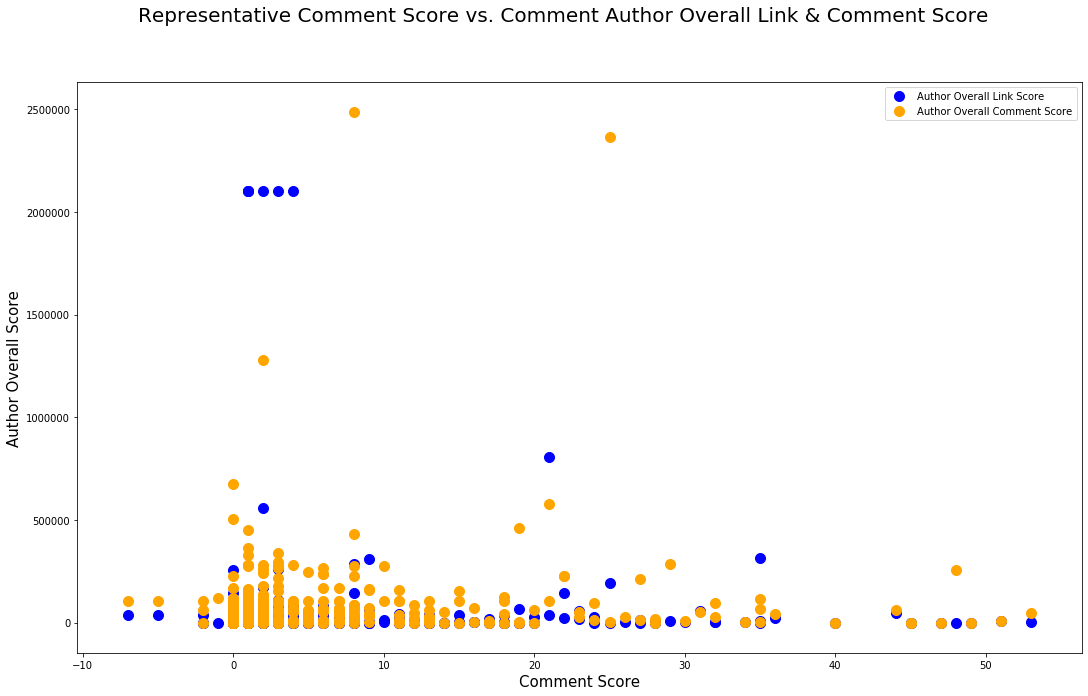

In [4]:
# get comments in a representative range, mainly to exclude outliers from high-scorers or banned accounts with 0 score
upvote_range = 50
median = comments_df['upvotes'].median()
top_comments = comments_df[comments_df['upvotes'].between(median - upvote_range, median + upvote_range)]


# arrange upvotes on x axis and link + comment score on y axis
scatter_x = np.concatenate([np.array(top_comments['upvotes']), np.array(top_comments['upvotes'])])
scatter_y = np.concatenate([np.array(top_comments['author_link_karma']), np.array(top_comments['author_comment_karma'])])

# assign legend groups to link and comment score, label blue and orange respectively
group = [1] * len(top_comments['author_link_karma']) + [2] * len(top_comments['author_comment_karma'])
cdict = {1: 'blue', 2: 'orange'}

# create scatter plot
fig, ax = plt.subplots()
fig.set_size_inches(18,10.5)

# for each legend group
for g in np.unique(group):
    # plot dots corresponding to this group
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)

# label plot
L = ax.legend()
L.get_texts()[0].set_text('Author Overall Link Score')
L.get_texts()[1].set_text('Author Overall Comment Score')
fig.suptitle('Representative Comment Score vs. Comment Author Overall Link & Comment Score', fontsize=20)
plt.xlabel('Comment Score', fontsize=15)
plt.ylabel('Author Overall Score', fontsize=15)
plt.show()

### **Analysis**
From the plot, we cannot infer any strong correlation between comment score and overall score. Contrary to what we might have expected, the distribution of overall link and comment scores is roughly unimodal with a mode somewhat below the median comment score. Scatter plots can be excellent at giving hints at the relationship between two variables like this.

### **Part 3b) Box Plot: Distributions of Score and Comments for Posts with Awards**
*Question: Can we compare the ranges and distributions of score and comment count for posts which have received reddit awards vs. those which have not?*

One good type of plot to answer this question is a box plot. We can construct a simple box plot with seaborn as shown:

For more information on the details of creating boxplots with seaborn, check the seaborn docs on boxplots: https://seaborn.pydata.org/generated/seaborn.boxplot.html. These docs also give examples on using seaborn to create a variety of other plots.

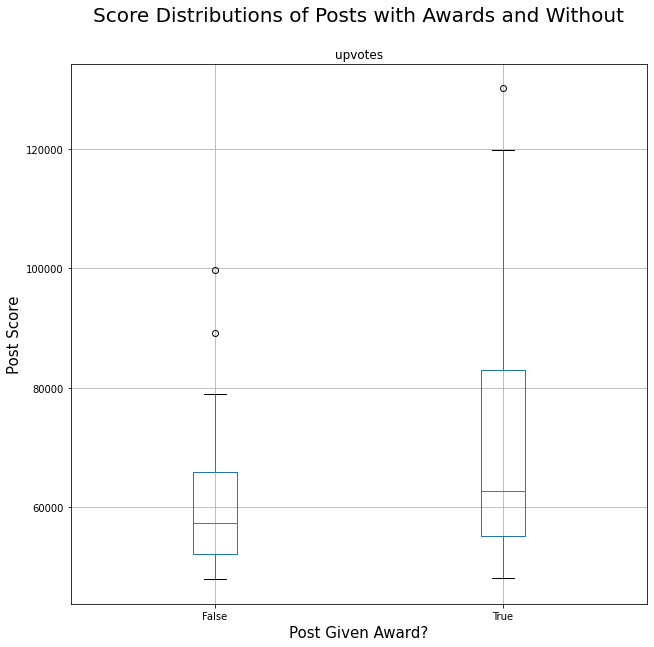

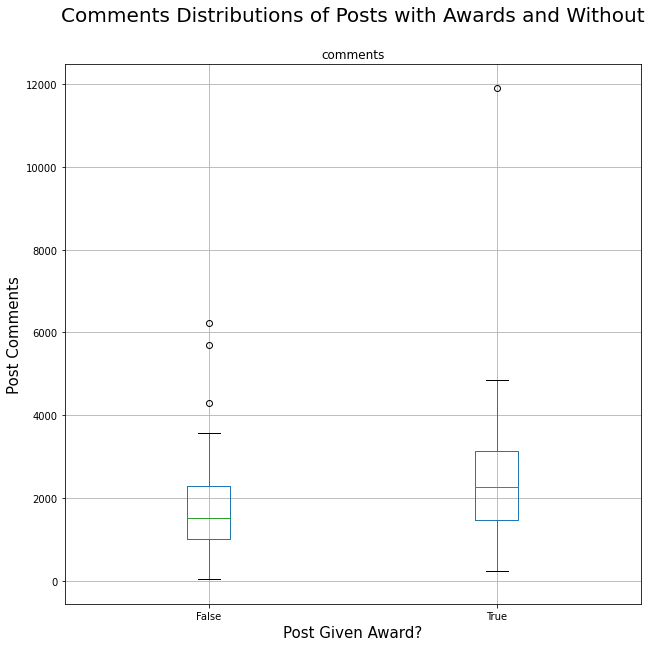

In [ ]:
# create boxplot showing upvotes by award status
fig, ax = plt.subplots(figsize=(10,  10))
posts_df.boxplot(['upvotes'], 'gilded', ax)
fig.suptitle('Score Distributions of Posts with Awards and Without', fontsize=20)
plt.xlabel('Post Given Award?', fontsize=15)
plt.ylabel('Post Score', fontsize=15)
plt.show()

# create boxplot showing comments by award status
fig, ax = plt.subplots(figsize=(10,  10))
posts_df.boxplot(['comments'], 'gilded', ax)
fig.suptitle('Comments Distributions of Posts with Awards and Without', fontsize=20)
plt.xlabel('Post Given Award?', fontsize=15)
plt.ylabel('Post Comments', fontsize=15)
plt.show()

### **Analysis**
From the first plot we can conclude that the range of scores within the 2nd and 3rd quartile increase significantly for posts that have been given awards, and the long tail representing the 4th quartile further suggests that the range of possibilities for post score among posts with awards is much greater than that of posts without awards. The second plot indicates a similar trend for comment counts of posts with awards, but the difference in 2nd and 3rd quartile range as well as 4th quartile range is not nearly as distinct in this case. These box plots imply that posts which receive awards are more likely to receive positive engagement and engagement overall.

## **Part 4) Hypothesis Testing**

Now that we have visualized our data sets containing reddit post information and reddit comment information, we can conduct some basic hypothesis testing to analyze the relationship between different sets of variables. In the following code we demonstrate linear regression with ordinary least squares to give us more detail about the relationships we looked at above. We use functions from statsmodels to acheive this. More information about these functions can be found here: https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

### **Part 4a) OLS: Comment Score vs. Comment Author Score**

Going back to the question we looked at above: 
*Question: For "representative" comments in the comments dataset, is there any correlation between the score a user got with their comment and their overall score on reddit as a whole?* 

We can first look at the relationship between comment score and comment author overall link score, then comment score and comment author overall comment score.

In [7]:
link_upvote_corr = sm.ols('author_link_karma~upvotes', data=top_comments).fit()
link_upvote_corr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      author_link_karma   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5311
Date:                Wed, 13 May 2020   Prob (F-statistic):              0.467
Time:                        16:38:26   Log-Likelihood:                -5300.3
No. Observations:                 381   AIC:                         1.060e+04
Df Residuals:                     379   BIC:                         1.061e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.178e+04   1.63e+04      3.801      0.000    2.98e+04    9.37e+04
upvotes    -1011.2805   1387.647     -0.729      0.467   -3739.731    1717.170
==============================================================================
Omnibus:                      528.402   Durbin-Watson:                   1.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45536.747
Skew:                           7.178   Prob(JB):                         0.00
Kurtosis:                      54.598   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Analysis

When we fit a linear regression model of author link karma vs. upvotes, and test for a relationship between upvotes and author link karma, we do not reject the null hypothesis of no relationship because we have a p value of 0.467 which is way above our significance level of 0.05. Our model says that for each upvote, there is a -1011 decrease in author link karma, but again, this is not statistically significant.

This isn't what one would expect, as you would probably expect that that the more upvotes you have on a comment, the higher link karma you have. However, we suspect the reason why it's such a large negative number is because some users' link karma is so high, it skewed the data. Looking at our scatter plot before, we see that there are a couple points that are above a million. When the comment ranges from -10 to 50, these outlier points can make a big difference on the slope of the line.

Now let’s look at the relationship between comment score and comment author overall comment score.

In [8]:
comment_upvote_corr = sm.ols('author_comment_karma~upvotes', data=top_comments).fit()
comment_upvote_corr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     author_comment_karma   R-squared:                       0.004
Model:                              OLS   Adj. R-squared:                  0.001
Method:                   Least Squares   F-statistic:                     1.455
Date:                  Wed, 13 May 2020   Prob (F-statistic):              0.229
Time:                          16:38:49   Log-Likelihood:                -5197.5
No. Observations:                   381   AIC:                         1.040e+04
Df Residuals:                       379   BIC:                         1.041e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.409e+04   1.24e+04      5.970      0.000    4.97e+04    9.85e+04
upvotes     1277.8026   1059.422      1.206      0.229    -805.278    3360.884
==============================================================================
Omnibus:                      602.829   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           138717.520
Skew:                           8.680   Prob(JB):                         0.00
Kurtosis:                      94.852   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Analysis

When we fit a linear regression model of author comment karma vs. upvotes, and test for a relationship between upvotes and author comment karma, we also do not reject the null hypothesis of no relationship because we have a p value of 0.229 which is above our significance level of 0.05. Our model says that for each upvote, there is a 1277 increase in author comment karma, but again, this is not statistically significant.  

This is what one would expect, as you would probably expect that that the more upvotes you have on a comment, the higher comment karma you have. However, the reason why the number is so big is because again, we have some outliers in the millions range. This probably skewed our data again despite our attempt to look at representative comments.

### **Part 4b) OLS: Comment Author Score vs. Comment Score, Gilded**

In addition, given what we saw with posts with awards vs without awards, we saw that the distribution of points was different for the two. With this information, it makes sense to check for an interaction term between number of upvotes and if their post recieved an award (for author comment/link karma).

First let’s take a look at this for author comment karma.

In [11]:
link_upvote_corr_inter = sm.ols('author_comment_karma~upvotes*gilded', data=posts_df).fit()
link_upvote_corr_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     author_comment_karma   R-squared:                       0.009
Model:                              OLS   Adj. R-squared:                 -0.022
Method:                   Least Squares   F-statistic:                    0.2759
Date:                  Wed, 13 May 2020   Prob (F-statistic):              0.843
Time:                          19:48:06   Log-Likelihood:                -1313.7
No. Observations:                   100   AIC:                             2635.
Df Residuals:                        96   BIC:                             2646.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5.712e+04   1.03e+05      0.557      0.579   -1.46e+05    2.61e+05
gilded[T.True]         -1.343e+04   1.21e+05     -0.111      0.912   -2.54e+05    2.27e+05
upvotes                   -0.2072      1.675     -0.124      0.902      -3.532       3.118
upvotes:gilded[T.True]     0.5119      1.887      0.271      0.787      -3.233       4.257
==============================================================================
Omnibus:                      117.057   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1808.453
Skew:                           4.055   Prob(JB):                         0.00
Kurtosis:                      22.190   Cond. No.                     9.96e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.96e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analysis

For author comment karma, when we check for an interaction term, we do not reject the null hypothedis for no relationship because we get a p value of 0.902 and 0.787, respectively, for the posts without and with awards. Our model says that for posts without awards, for every upvote, there is a 0.207 decrease in the author's comment karma, and for posts with awards, for every upvote, there is an 0.304 increase in the author's comment karma. This makes sense as if a post has an award, the author of the comment is probably good at writing comments, but again, these are not statistically significant results. 

Now, let’s take a look at this for author link karma.

In [12]:
link_upvote_corr_inter = sm.ols('author_link_karma~upvotes*gilded', data=posts_df).fit()
link_upvote_corr_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      author_link_karma   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.6688
Date:                Wed, 13 May 2020   Prob (F-statistic):              0.573
Time:                        19:48:47   Log-Likelihood:                -1512.0
No. Observations:                 100   AIC:                             3032.
Df Residuals:                      96   BIC:                             3042.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5.618e+05   7.45e+05      0.754      0.453   -9.18e+05    2.04e+06
gilded[T.True]          4.552e+05    8.8e+05      0.517      0.606   -1.29e+06     2.2e+06
upvotes                   -3.3223     12.173     -0.273      0.785     -27.485      20.841
upvotes:gilded[T.True]    -5.3551     13.711     -0.391      0.697     -32.571      21.861
==============================================================================
Omnibus:                      134.918   Durbin-Watson:                   1.388
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3407.970
Skew:                           4.801   Prob(JB):                         0.00
Kurtosis:                      29.939   Cond. No.                     9.96e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.96e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analysis

For author link karma, when we check for an interaction term, we do not reject the null hypothedis for no relationship because we get a p value of 0.785 and 0.697, respectively, for posts without and with awards. Our model says that for posts without awards, for every upvote, there is a 3.322 decrease in the author's link karma, and for posts with awards, for every upvote, there is an 8.677 decrease in the author's link karma. This doesn't make a lot of sense as you would expect authors of posts with awards to have more karma, but the outliers could be skewing the data again. But again, these are not statistically significant results. 

### **Part 4c) OLS: Upvotes vs. Comment Author Score, Author Link Karma, Comments, Crossposts**

Now that we've attempted to predict the author's credentials, let's focus on the upvotes. We want to see what influences the number of upvotes a post gets (in the top 100 posts). 

We, again, run linear regression.

In [55]:
multi_res = sm.ols('upvotes~author_comment_karma+author_link_karma+comments+crossposts', data=posts_df).fit()
multi_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                upvotes   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     12.32
Date:                Wed, 13 May 2020   Prob (F-statistic):           4.13e-08
Time:                        21:35:31   Log-Likelihood:                -1096.0
No. Observations:                 100   AIC:                             2202.
Df Residuals:                      95   BIC:                             2215.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             5.339e+04   2700.912     19.766      0.000     4.8e+04    5.87e+04
author_comment_karma    -0.0067      0.013     -0.522      0.603      -0.032       0.019
author_link_karma       -0.0022      0.002     -1.357      0.178      -0.005       0.001
comments                 2.1942      0.958      2.290      0.024       0.292       4.097
crossposts             479.1908     81.380      5.888      0.000     317.631     640.751
==============================================================================
Omnibus:                       21.912   Durbin-Watson:                   0.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.856
Skew:                           1.063   Prob(JB):                     3.29e-07
Kurtosis:                       4.626   Cond. No.                     1.85e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analysis

We find that the statistically significant variables (our threshold is 0.05) that affect number of upvotes are number of comments and number of crossposts. The number of comments has a p value of 0.024 and the number of crossposts has a p value that's basically 0. For every comment, there is a 2.194 increase in the number of upvotes. For every crosspost, there is 479.191 increase in the number of upvotes. This makes sense as if a post has more comments, it probably engages the audience more so they are likely to respond well to it, resulting in a higher number of upvotes. It also makes sense for the crossposts because if a post reaches multiple subreddits, it reaches a larger audience which means more chances for people to engage with the post. It is somewhat surprising as we didn't expect the crosspost coefficient to be so high. It's also somewhat surprising that the variables related to the author don't contribute much to the number of upvotes. This is likely due to the nature of reddit as it tends to focus more on the content rather than who makes it (as opposed to other forms of media like Youtube where creators typically have a strong following). 

## Part 5) **Machine Learning**

Now that we have examined the relationship between number of upvotes a post has and the credentials of its author, let's examine the post further. 

We want to try to see if we can predict if a post gets an award using author link karma, author comment karma, number of upvotes, upvote ratio, number of comments, and number of crossposts. We chose these specific attributes because we wanted to look at the audience, their reaction and the author's credentials as opposed to the type of post. 

First, we clean up the data into a nice form to input into a random forest classifier. 

In [53]:
X = posts_df[['author_link_karma','author_comment_karma', 'upvotes','upvote_ratio','comments','crossposts']].to_numpy()
# get the outcome from the dataframe we created
posts_df['y'] = 1
posts_df['y'] = posts_df['y'].where(posts_df['gilded'] == False, 0)
y = posts_df['y'].to_numpy()

We chose to use a random forest classifier because they tend to be pretty reliable and robust. They try to improve prediction performance and reduce instability by averaging multiple decision trees. We use 100 trees and 10 fold cross validation to check our error rate. We also extract ROC data to get AUROC data for a visual for our error rate. You can learn more about random forest classifiers here: https://towardsdatascience.com/understanding-random-forest-58381e0602d2


The following code is adapted from this sklearn tutorial: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py. Read more to find out additional information and use the sklearn docs to get details on using more models.

In [45]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)

parameters = {'max_features': ['auto', 'sqrt', 'log2']} 
cv = sklearn.model_selection.GridSearchCV(rf, parameters, cv=10)

cv_obj = sklearn.model_selection.StratifiedKFold(n_splits=10)


def get_roc_data(model, cv_obj):
    curve_df = None
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (train, test) in enumerate(cv_obj.split(X, y)):
        model.fit(X[train], y[train])
        scores = model.predict_proba(X[test])[:,1]
        fpr, tpr, _ = sklearn.metrics.roc_curve(y[test],scores)
        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tmp = pd.DataFrame({'fold':i, 'fpr': mean_fpr, 'tpr': interp_tpr})
        curve_df = tmp if curve_df is None else pd.concat([curve_df, tmp])
        
        aucs.append(sklearn.metrics.auc(fpr, tpr))
        
    curve_df = curve_df.groupby('fpr').agg({'tpr': 'mean'}).reset_index()
    curve_df.iloc[-1,1] = 1.0
    
    auc_df = pd.DataFrame({'fold': np.arange(len(aucs)), 'auc': aucs})
    return curve_df, auc_df

In [46]:
# get roc curve data for  model
curve_df, auc_df = get_roc_data(cv, cv_obj)
curve_df['model'] = 'm'
auc_df['model'] = 'm'

In [47]:
auc_df

,fold,auc,model
0,0,0.666667,m
1,1,0.660000,m
2,2,0.680000,m
3,3,0.800000,m
4,4,0.500000,m
5,5,0.800000,m
6,6,0.720000,m
7,7,0.360000,m
8,8,0.500000,m
9,9,0.720000,m


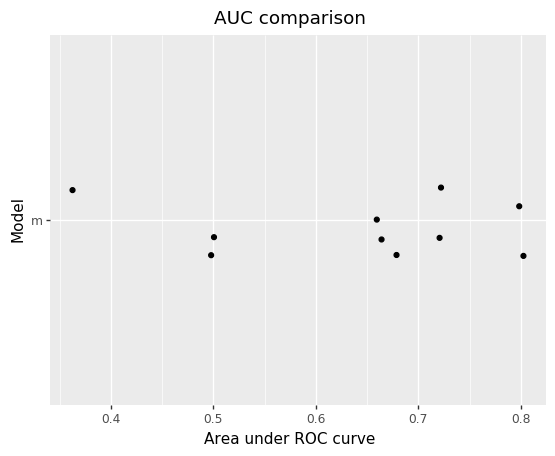

<ggplot: (304764431)>

In [50]:
# plot the distribution of auc estimates
(ggplot(auc_df, aes(x='model', y='auc')) + 
     geom_jitter(position=position_jitter(0.1)) +
     coord_flip() +
     labs(title = "AUC comparison",
          x="Model",
          y="Area under ROC curve"))

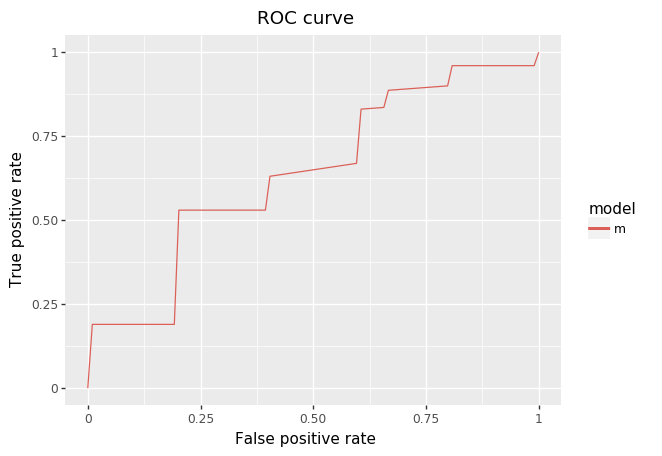

<ggplot: (304856100)>

In [54]:
mean_curve_df = curve_df.groupby(['model','fpr']).agg({'tpr': 'mean'}).reset_index()
(ggplot(mean_curve_df, aes(x='fpr', y='tpr', color='model')) +
    geom_line() +
    labs(title = "ROC curve",
         x = "False positive rate",
         y = "True positive rate"))

### Analysis

We want to have a more log shaped curve for the ROC curve, but we have a more linear curve, indicating that our model was not very accurate in predicting if a post recieved an award. You can learn more about the ROC curve here: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5